In [1]:
import os
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.patheffects import Normal, Stroke
import numpy as np
import seaborn as sns
from ezephys import pltools

import heidelberg

In [2]:
digits = heidelberg.Data(
    os.path.join('..', 'data', 'shd_train.h5'),
    os.path.join('..', 'data', 'shd_test.h5'),
)

def get_minibatch():
    with digits as d:
        for x, y in heidelberg.sparse_data_generator_from_hdf5_spikes(
            d.x_train, 
            d.y_train, 
            heidelberg.SWEEP_DURATION, 
            shuffle=False
        ):
            break
    return x, y

In [3]:
x, y = get_minibatch()

In [4]:
def tensor_to_events(tensor):
    return [np.nonzero(tensor[i, :]).flatten() for i in range(tensor.shape[0])]

def savefig(fname, **pltargs):
    plt.savefig(fname + '.png', dpi=300, bbox_inches='tight', **pltargs)
    plt.savefig(fname + '.svg', dpi=300, bbox_inches='tight', **pltargs)

In [5]:
numbers = (
    'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 
    'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen'
)

/home/efharkin/.miniconda3/envs/lnldend/lib/python3.8/site-packages/numpy/core/fromnumeric.py:58: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /tmp/pip-req-build-ojg3q6e4/torch/csrc/utils/python_arg_parser.cpp:882.)
  return bound(*args, **kwds)


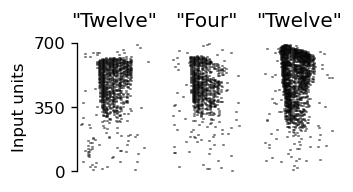

In [6]:
plt.figure(figsize=(3, 1.7), dpi=120)

for i, example in enumerate([14, 221, 53]):
    plt.subplot(1, 3, i+1)
    plt.title(f'\"{numbers[y[example]].capitalize()}\"')
    plt.eventplot(tensor_to_events(x.to_dense()[example, ...].T), color='k')
    
    if i == 0:
        plt.yticks([0, 350, 700])
        plt.ylabel('Input units')
        pltools.hide_border('trb', trim=True)
    else:
        pltools.hide_border()

plt.tight_layout()

savefig(os.path.join('..', 'data', 'heidelberg_examples'))

plt.show()

In [7]:
DATA_FILE_PREFIX = os.path.join('..', 'data', 'heidelberg_training_results_')

performance = []

for i in range(3):
    single_seed_performance = pd.read_csv(DATA_FILE_PREFIX + str(i) + '.csv')
    single_seed_performance['seed'] = i

    performance.append(single_seed_performance)

performance = pd.concat(performance).reset_index(drop=True)

In [8]:
performance.head()

,model_name,epoch,loss,accuracy,seed
0,One compartment,0,3.500723,0.101436,0
1,One compartment,1,2.816424,0.167213,0
2,One compartment,2,2.745782,0.201487,0
3,One compartment,3,2.694151,0.227823,0
4,One compartment,4,2.663931,0.230217,0


In [9]:
performance.query('epoch == 199').groupby(['model_name']).mean()

,epoch,loss,accuracy,seed
model_name,,,,
BAP,199,0.027552,0.995464,1
No BAP,199,0.050494,0.987525,1
One compartment,199,0.176457,0.949891,1
Parallel subunits + BAP (full PRC model),199,0.134287,0.957829,1
"Parallel subunits, no BAP",199,0.099527,0.969506,1


Load accuracy on test dataset.

In [10]:
DATA_FILE_PREFIX = os.path.join('..', 'data', 'heidelberg_test_accuracy_')

test = []

for i in range(3):
    single_seed_performance = pd.read_json(DATA_FILE_PREFIX + str(i) + '.json', orient='index')
    single_seed_performance['seed'] = i

    test.append(single_seed_performance)

test = pd.concat(test)
test['model_name'] = test.index
test.reset_index(drop=True, inplace=True)
test = test.melt(['model_name', 'seed'], ['initial', 'final'], var_name='time', value_name='accuracy')
test.head()

,model_name,seed,time,accuracy
0,One compartment,0,initial,0.047363
1,No BAP,0,initial,0.054199
2,BAP,0,initial,0.068848
3,"Parallel subunits, no BAP",0,initial,0.020996
4,Parallel subunits + BAP (full PRC model),0,initial,0.040039


In [11]:
test.groupby(['model_name', 'time']).mean()

seed  accuracy
model_name                               time                   
BAP                                      final       1  0.694661
                                         initial     1  0.059082
No BAP                                   final       1  0.647949
                                         initial     1  0.055990
One compartment                          final       1  0.603027
                                         initial     1  0.047526
Parallel subunits + BAP (full PRC model) final       1  0.556152
                                         initial     1  0.032715
Parallel subunits, no BAP                final       1  0.544108
                                         initial     1  0.034993

In [16]:
train_plot_data = performance.query('epoch in [0, 199]').copy()
train_plot_data.loc[:, 'Epoch'] = train_plot_data.epoch.astype(str)
train_plot_data.replace('0', 'Before training', inplace=True)
train_plot_data.replace('199', 'After training', inplace=True)

test_plot_data = test.query('time == \"final\"').copy()
test_plot_data.rename(columns={'time': 'Epoch'}, inplace=True)
test_plot_data.replace('final', 'Test data', inplace=True)

swarmplot_data = pd.concat([train_plot_data, test_plot_data])
del train_plot_data, test_plot_data

swarmplot_data.reset_index(inplace=True, drop=True)
swarmplot_data.head()

,model_name,epoch,loss,accuracy,seed,Epoch
0,One compartment,0.0,3.500723,0.101436,0,Before training
1,One compartment,199.0,0.173304,0.950353,0,After training
2,No BAP,0.0,13.972455,0.074849,0,Before training
3,No BAP,199.0,0.025517,0.996472,0,After training
4,BAP,0.0,16.394623,0.073337,0,Before training


In [17]:
palette = {
    'One compartment': 'gray',
    'No BAP': 'xkcd:ocean',
    'BAP': 'xkcd:cherry',
    'Parallel subunits, no BAP': 'xkcd:iris',
    'Parallel subunits + BAP (full PRC model)': 'xkcd:blood orange'
}

In [18]:
def performance_lineplot(model_name, metric_loss=True, ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()

    if metric_loss:
        metric = 'loss'
    else:
        metric = 'accuracy'

    this_model = performance.query('model_name == @model_name')
    if 'label' not in pltargs:
        pltargs['label'] = model_name
    for seed in this_model.seed.unique():
        this_seed = this_model.query('seed == @seed')
        ax.plot(
            this_seed.epoch,
            this_seed[metric],
            label=pltargs.pop('label', None),
            **pltargs
        )
        

def performance_bandplot(model_name, metric_loss=True, ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()

    if metric_loss:
        metric = 'loss'
    else:
        metric = 'accuracy'

    alpha = min(pltargs.pop('alpha', 1), 0.8)

    this_model = performance.query('model_name == @model_name').sort_values(
        'epoch'
    )
    if 'label' not in pltargs:
        pltargs['label'] = model_name

    this_mean = (
        this_model.groupby(['model_name', 'epoch']).mean().sort_values('epoch')
    )

    label = pltargs.pop('label', None)
    maincolor = pltargs.pop('color', None)
    ax.plot(
        this_mean.index.get_level_values('epoch'),
        this_mean[metric],
        color=maincolor,
        label=label,
        **pltargs
    )

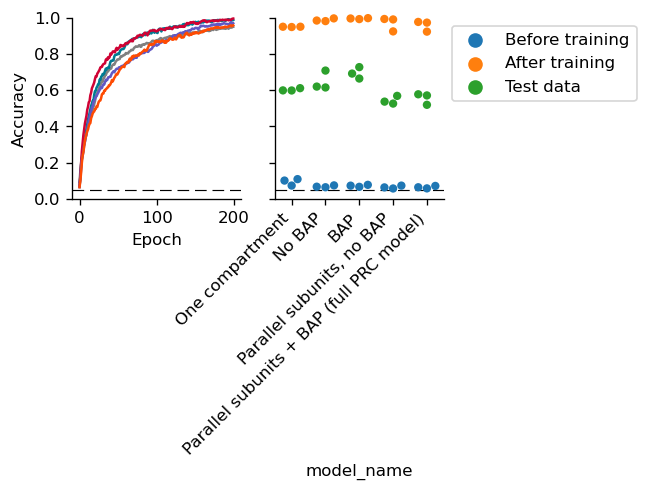

In [41]:
plt.figure(figsize=(4, 2), dpi=120)


plt.subplot(121)
plt.axhline(0.05, color='k', ls='--', dashes=(10, 5), lw=0.7, zorder=-1)
for model_name in palette:
    performance_bandplot(
        model_name, metric_loss=False, 
        color=palette[model_name], alpha=0.4, clip_on=False
    )

#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xticks([0, 100, 200])
plt.xlabel('Epoch')

pltools.hide_border('tr')

plt.subplot(122)
plt.axhline(0.05, color='k', ls='--', dashes=(10, 5), lw=0.7, zorder=-1)
plt.subplots_adjust(wspace=0.2)
sns.swarmplot(
    x='model_name',
    y='accuracy',
    hue='Epoch',
    clip_on=False,
    data=swarmplot_data,
)
plt.legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, 1)
plt.gca().set_yticklabels([])
plt.ylabel('')
plt.xticks(rotation=45, ha='right')

pltools.hide_border('tr')

savefig(os.path.join('..', 'data', 'heidelberg_performance_comparison'))

plt.show()